# Plot similar figure with simulationd data (using 1,000 Genomes project)

In [62]:
import admix
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [63]:
# specify parameters
N_INDIV = 10000
STEP = 10

In [64]:
CHROM = 1
KG_PATH = f"/u/project/pasaniuc/kangchen/DATA/plink2-1kg/out/build38.chr{CHROM}"

In [65]:
def GG(admix_ld, i, j):
    """
    Obtain
    gi1 x gj1, gi1 x gj2
    gj1 x gi2, gi2 x gj2

    Note that the matrix is not symmetric
    """
    ld1, ld2, ld12 = admix_ld["11"], admix_ld["22"], admix_ld["12"]
    return np.array([[ld1[i, j], ld12[i, j]], [ld12[j, i], ld2[i, j]]])

In [66]:
region_i = 0

In [67]:
df_regions = pd.read_csv(
    "../02-region-locus-simulate/out/regions.txt", delim_whitespace=True
)
ref_dset = admix.io.read_dataset(KG_PATH)
ref_dset = ref_dset[
    (
        (ref_dset.snp.CHROM == df_regions.CHROM[region_i])
        & (
            ref_dset.snp.POS.between(
                df_regions.START[region_i], df_regions.STOP[region_i]
            )
        )
    ).values
]
ref_dset = ref_dset[0:(ref_dset.n_snp // 10):STEP]
ref_dset_list = [
    ref_dset[:, (ref_dset.indiv.SuperPop == pop).values] for pop in ["EUR", "AFR"]
]

mosaic_size = admix.simulate.calculate_mosaic_size(
    df_snp=ref_dset.snp, genetic_map="hg38", chrom=1, n_gen=7
)

np.random.seed(1)
dset, lanc = admix.simulate.admix_geno(
    geno_list=[dset.geno for dset in ref_dset_list],
    df_snp=ref_dset.snp,
    anc_props=[0.05, 0.95],
    mosaic_size=mosaic_size,
    n_indiv=N_INDIV,
    return_sparse_lanc=True,
)
dset.snp[["FREQ1", "FREQ2"]] = dset.af_per_anc()
dset = dset[(dset.snp.FREQ1.between(0.01, 0.99) & dset.snp.FREQ2.between(0.01, 0.99)).values]

admix.data.af_per_anc: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


In [68]:
ld = np.corrcoef(dset.geno.sum(axis=2)).compute()

<AxesSubplot:>

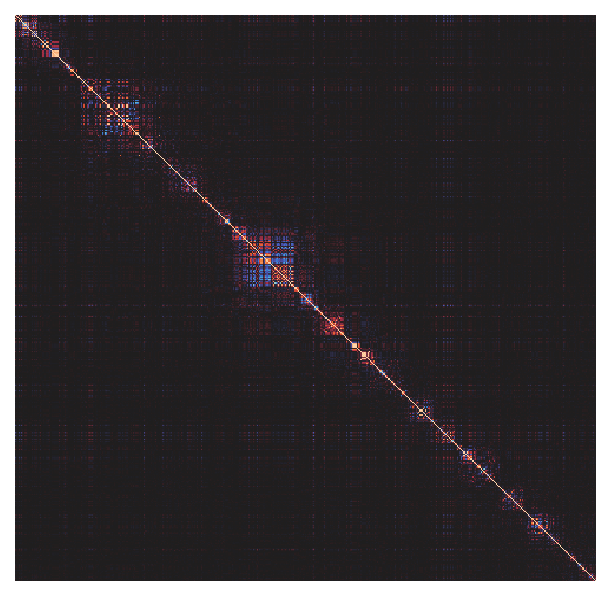

In [70]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
sns.heatmap(ld, center=0, vmin=-1, vmax=1, ax=ax, cbar=False, xticklabels=False, yticklabels=False)

In [29]:
admix_ld = admix.data.admix_ld(dset)

res = []
for i in range(dset.n_snp):
    for j in range(dset.n_snp):
        GiGi = GG(admix_ld, i, i)
        GiGj = GG(admix_ld, i, j)
        tag = np.linalg.inv(GiGi) @ GiGj @ np.ones(2)[:, None]
        res.append([dset.snp.POS[i], dset.snp.POS[j]] + tag.flatten().tolist())
df_plot = pd.DataFrame(res, columns=["posi", "posj", "ld1", "ld2"])
df_plot["dist"] = np.abs(df_plot["posi"] - df_plot["posj"]) / 1e6

In [30]:
from scipy.stats import ttest_rel

In [34]:
0.05 * 1e3

50.0

In [31]:
df_tmp = df_plot[df_plot.dist < 0.05]

In [32]:
ttest_rel(df_tmp["ld1"], df_tmp["ld2"])

Ttest_relResult(statistic=0.35090176313387816, pvalue=0.7256666485057939)

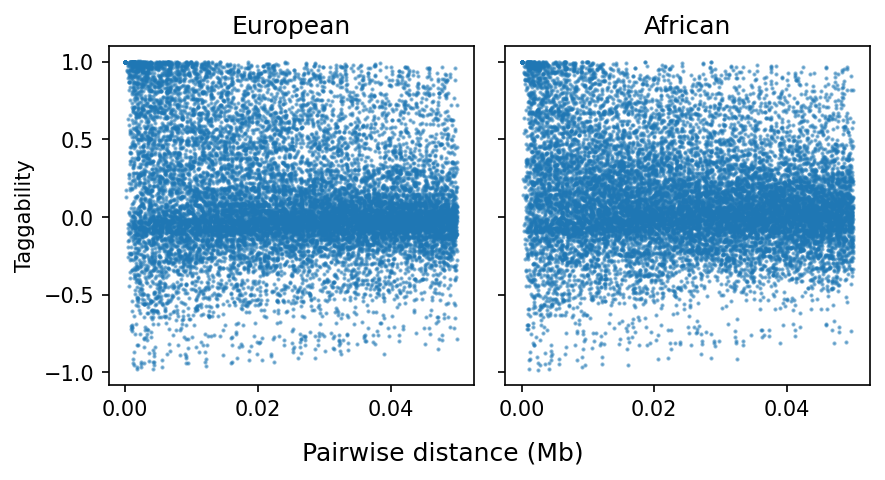

In [35]:
fig, axes = plt.subplots(figsize=(6, 3), dpi=150, ncols=2, sharey=True)
axes[0].scatter(df_tmp["dist"], df_tmp["ld1"], s=1, alpha=0.5)
axes[1].scatter(df_tmp["dist"], df_tmp["ld2"], s=1, alpha=0.5)

axes[0].set_ylabel("Taggability")

axes[0].set_title("European")
axes[1].set_title("African")

fig.text(0.5, -0.04, "Pairwise distance (Mb)", ha="center", fontsize=12)
fig.tight_layout()

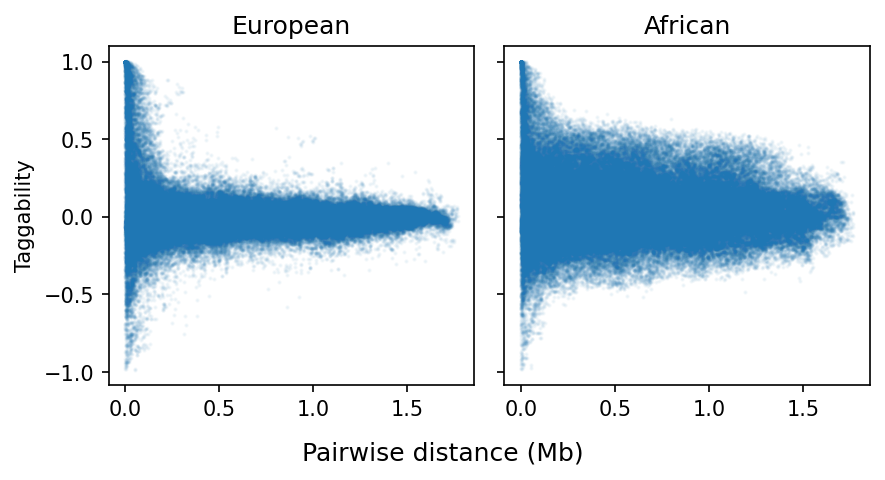

In [37]:
fig, axes = plt.subplots(figsize=(6, 3), dpi=150, ncols=2, sharey=True)
axes[0].scatter(df_plot["dist"], df_plot["ld1"], s=1, alpha=0.05)
axes[1].scatter(df_plot["dist"], df_plot["ld2"], s=1, alpha=0.05)

axes[0].set_ylabel("Taggability")

axes[0].set_title("European")
axes[1].set_title("African")

fig.text(0.5, -0.04, "Pairwise distance (Mb)", ha="center", fontsize=12)
fig.tight_layout()